## Model Explainability Notebook

In [1]:
# Add src and config to path
import sys
from pathlib import Path
import pandas as pd

sys.path.append("../src")
sys.path.append("../")

output_path = "../output"

from xai_pkg.model_explainer.utils import flatten_explanations

# Load explanations data
explanations_path = f"{output_path}/llm_explanations/explanations.json"

## Load model and SHAP explainer

In [2]:
from xai_pkg.model_explainer.predictor import CreditPredictor
from xai_pkg.model_explainer.shap_explainer import SHAPExplainer
from xai_pkg.model_explainer.base_explainer import BaseExplainer
from matplotlib import pyplot as plt
import shap
import numpy as np

# Load test & training data
X_train = pd.read_csv('../data/processed/X_train_undersampled.csv')
df_test = pd.read_csv('../data/raw/cs-test.csv')

# Set figure size
fs = (15, 7)

model = CreditPredictor.load_model()
base_explainer = BaseExplainer(model)
shap_explainer = SHAPExplainer(base_explainer, model_training_data=X_train, suppress_shap_warnings=True)

print(f"✅ SHAP explainer initialized with {len(X_train)} background samples")
display(df_test.head())

INFO:xai_pkg.model_explainer.predictor:CreditPredictor initialized with XGBoost model
INFO:xai_pkg.model_explainer.predictor:Model loaded from ../output/models/best_model.pkl
INFO:xai_pkg.model_explainer.base_explainer:BaseExplainer initialized with XGBoost model. Features: 11
INFO:xai_pkg.model_explainer.shap_explainer:SHAP Explainer initialized successfully with logit link


✅ SHAP explainer initialized with 34757 background samples


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


## SHAP Waterfall Plot - Single Instance

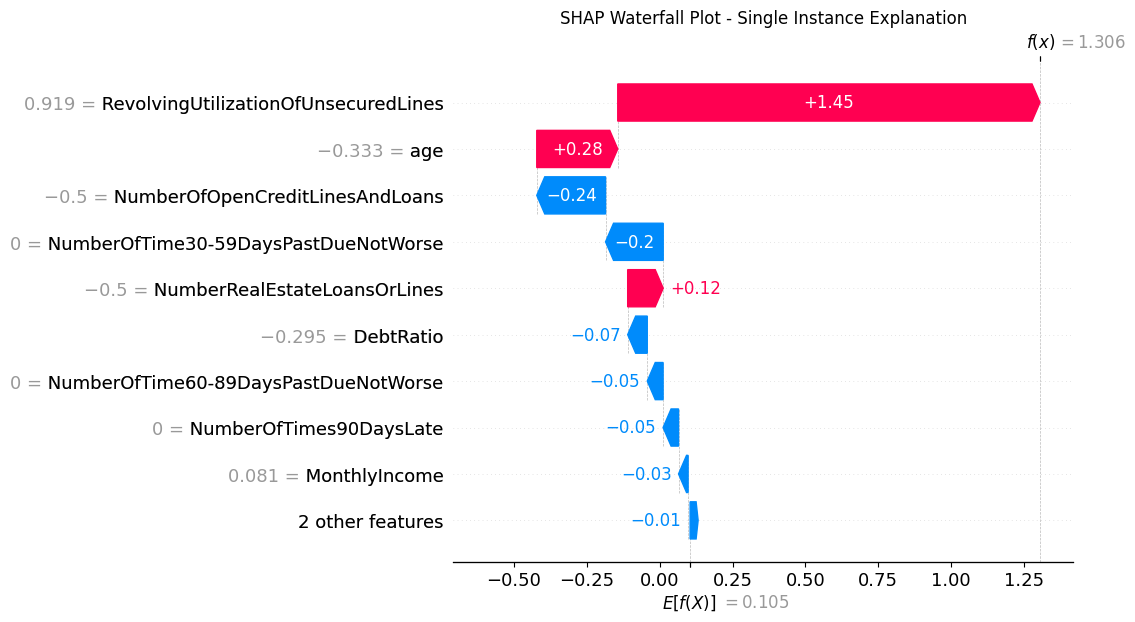

In [3]:
# SHAP waterfall plot for a single prediction

# Get a single instance and preprocess it
single_instance = df_test.iloc[0:1].copy()
processed_instance = base_explainer.predictor._preprocess_input(single_instance, keep_target=False)
processed_instance = base_explainer.preprocessor.transform(processed_instance)

# Get SHAP explanation for the instance
shap_explanation = shap_explainer.explainer(processed_instance)

# Create waterfall plot
plt.figure(figsize=fs)
shap.plots.waterfall(shap_explanation[0], show=False)
plt.title('SHAP Waterfall Plot - Single Instance Explanation')
plt.show()

## SHAP Feature Importance & Beeswarm plots

Using 200 samples for SHAP visualization


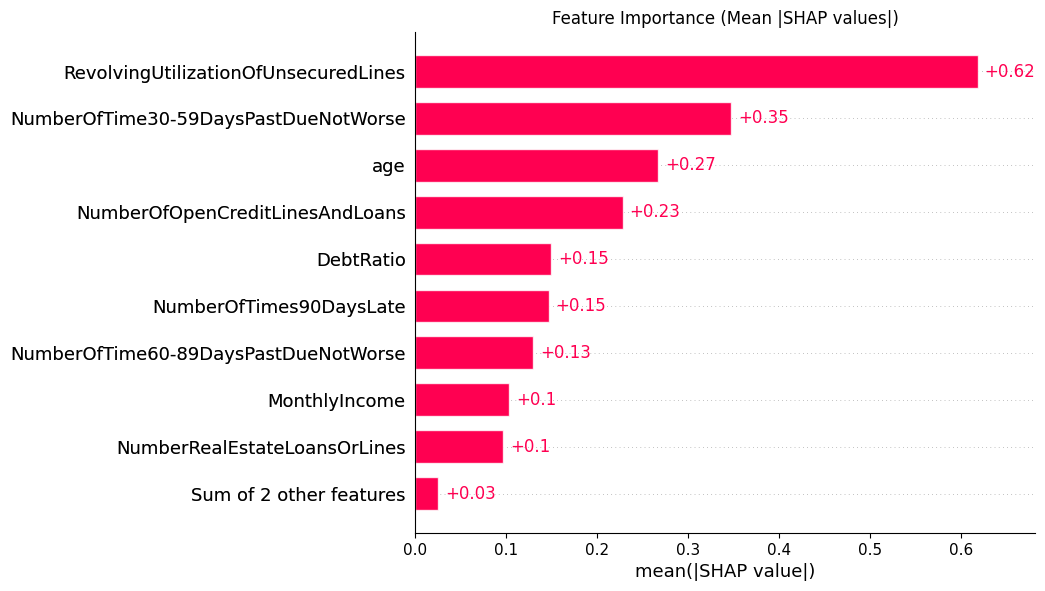

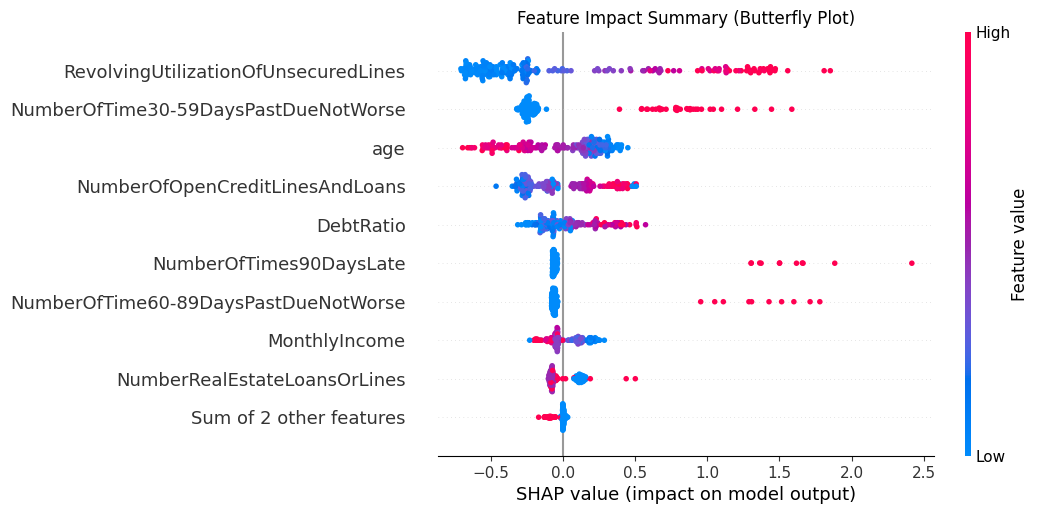

In [4]:
# Feature importance plots using SHAP's built-in functions

# Sample data for plotting
df_sampled = df_test.sample(n=200, random_state=42)  # Smaller sample for faster processing
print(f"Using {len(df_sampled)} samples for SHAP visualization")

# Preprocess the sample data to match model input format
processed_sample = base_explainer.predictor._preprocess_input(df_sampled, keep_target=False)
processed_sample = base_explainer.preprocessor.transform(processed_sample)

# Get SHAP values directly from the explainer for plotting
shap_values = shap_explainer.explainer(processed_sample)

# Feature importance bar plot (mean absolute SHAP values)
plt.figure(figsize=fs)
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title('Feature Importance (Mean |SHAP values|)')
plt.show()

# Butterfly/Summary plot - shows feature importance and impact direction
plt.figure(figsize=fs)
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title('Feature Impact Summary (Butterfly Plot)')
plt.show()

## Analyse LLM-based explanations

## 🧪 Test Custom Customer Profile


In [5]:
# 🧪 Interactive Customer Profile Testing
# Modify the values below to test different customer profiles!

# Example customer profile - modify these values as needed
test_customer = {
    'age': 35,                                              # Customer age (years)
    'MonthlyIncome': 6000,                                  # Monthly income ($)
    'DebtRatio': 0.15,                                      # Debt-to-income ratio (0-1, where 0.15 = 15%)
    'RevolvingUtilizationOfUnsecuredLines': 0.3,           # Credit utilization (0-1, where 0.3 = 30%)
    'NumberOfOpenCreditLinesAndLoans': 8,                  # Number of open credit lines/loans
    'NumberRealEstateLoansOrLines': 1,                     # Number of real estate loans
    'NumberOfDependents': 2,                               # Number of dependents
    'NumberOfTime30-59DaysPastDueNotWorse': 0,             # Number of 30-59 day late payments
    'NumberOfTime60-89DaysPastDueNotWorse': 0,             # Number of 60-89 day late payments
    'NumberOfTimes90DaysLate': 0                           # Number of 90+ day late payments
}


# Generate prediction
print("\n🔮 Making Prediction...")
prediction_result = model.predict_single(test_customer, verbose=False)

print(f"Decision: {'❌ DECLINED' if prediction_result['prediction'] == 1 else '✅ APPROVED'}")
print(f"Risk Probability: {prediction_result['probability']:.1%}")
print(f"Prediction ID: {prediction_result['prediction_id']}")



🔮 Making Prediction...
Decision: ✅ APPROVED
Risk Probability: 46.7%
Prediction ID: pred_824d87f7


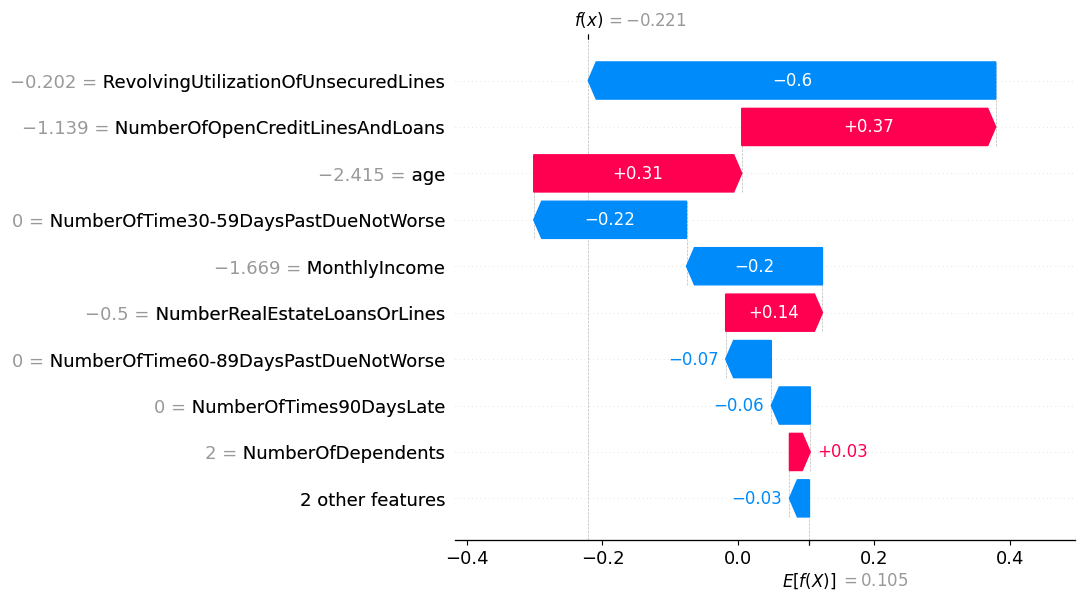

In [6]:
# 📊 Create Waterfall Plot for Custom Customer using the SHAPExplainer class

# Get preprocessed customer data for SHAP explainer
processed_customer = model._preprocess_input(test_customer, keep_target=False)
processed_customer = model.model_preprocessor.transform(processed_customer)

explanation = shap_explainer.explain_single(processed_customer)

shap_explainer.print_waterfall(explanation)

## Counterfactuals verification

In [7]:
# Load DiCE baseline results
from xai_pkg.sampling.utils import load_predictions

predictions, metadata = load_predictions(predictions_file="../output/predictions/prediction_results_sampled.json")

df = pd.DataFrame(predictions)

df.head()

,prediction_id,prediction,probability,input_RevolvingUtilizationOfUnsecuredLines,input_age,input_NumberOfTime30-59DaysPastDueNotWorse,input_DebtRatio,input_MonthlyIncome,input_NumberOfOpenCreditLinesAndLoans,input_NumberOfTimes90DaysLate,...,shap_NumberOfTimes90DaysLate,shap_imputed_income,shap_model_probability,shap_shap_sum_logit,shap_shap_probability,shap_difference,cf_count,counterfactuals,cf_percentile_changes,cf_avg_percentile_change
0,pred_ac72d9e2,0,0.250628,0.050836,68.0,0.0,0.260162,16900.0,15.0,0.0,...,-0.072173,0.0,0.250628,-1.095265,0.250628,1.152536e-08,3,"[{'MonthlyIncome': {'from': 16900.0, 'to': 177...","[0.23016946226660195, 0.20715251603992613, 0.2...",0.214825
1,pred_913f4465,0,0.200567,0.019154,47.0,0.0,0.139386,10000.0,5.0,0.0,...,-0.068456,0.0,0.200567,-1.382754,0.200567,1.242209e-08,3,"[{'MonthlyIncome': {'from': 10000.0, 'to': 785...","[3.2784762781598005, 13.447650832925746, 13.44...",10.057926
2,pred_0e0ca9e1,0,0.464743,0.053522,69.0,0.0,0.579474,3000.0,18.0,0.0,...,-0.067957,0.0,0.464743,-0.141264,0.464743,1.968858e-09,1,"[{'MonthlyIncome': {'from': 3000.0, 'to': 2807...",[1.6974997842161308],1.697500
3,pred_fc28c4e6,0,0.453995,0.033216,48.0,0.0,0.368787,5894.0,30.0,0.0,...,-0.064983,0.0,0.453995,-0.184541,0.453995,2.562994e-09,3,"[{'MonthlyIncome': {'from': 5894.0, 'to': 2300...","[12.99594326322756, 36.97960123140662, 36.9796...",28.985049
4,pred_35ed9fc9,0,0.462092,0.053541,50.0,0.0,0.694733,2600.0,7.0,0.0,...,-0.063826,0.0,0.462092,-0.151925,0.462092,2.115792e-09,3,"[{'MonthlyIncome': {'from': 2600.0, 'to': 2388...","[1.993842966884369, 1.993842966884369, 1.99384...",1.993843


In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xai_pkg.model_explainer.predictor import CreditPredictor

# Load model and data
predictor = CreditPredictor.load_model(
    model_filepath='../output/models/best_model.pkl',
    model_metadata_filepath='../output/models/model_metadata.json'
)

with open('../output/predictions/prediction_results_sampled.json', 'r') as f:
    sampled_data = json.load(f)

# Analyze DICE counterfactual validity by position (CF1, CF2, CF3)
cf_results = {'CF1': [], 'CF2': [], 'CF3': []}

for pred_id, data in sampled_data['predictions'].items():
    original_prediction = data['prediction']['prediction']

    # Only test rejected applications (prediction=1)
    if original_prediction != 1:
        continue

    original_input = data['prediction']['input_data']
    counterfactuals = data['counterfactuals']

    # Test each counterfactual position
    for cf_pos, cf in enumerate(counterfactuals):
        if cf_pos >= 3:  # Only test first 3
            break

        # Apply counterfactual changes
        modified_input = original_input.copy()
        for feature, change in cf.items():
            if isinstance(change, dict) and 'to' in change:
                modified_input[feature] = change['to']

        # Predict
        try:
            cf_result = predictor.predict_single(modified_input)
            cf_prediction = cf_result['prediction']
            flipped = cf_prediction != original_prediction

            cf_key = f'CF{cf_pos + 1}'
            cf_results[cf_key].append(flipped)

        except Exception as e:
            print(f'Error with {pred_id} CF{cf_pos + 1}: {e}')

# Calculate flip rates
flip_rates = {}
for cf_pos, flips in cf_results.items():
    if flips:
        flip_rates[cf_pos] = sum(flips) / len(flips) * 100
    else:
        flip_rates[cf_pos] = 0

# Store flip rate for first position for later baseline comparison
baseline_flip_rate = flip_rates['CF1']
print(f"Baseline flip rate: {baseline_flip_rate}%")

# Print results
print("DICE Counterfactual Validity Rates (Rejected Applications Only):")
for cf_pos, rate in flip_rates.items():
    total = len(cf_results[cf_pos])
    valid = sum(cf_results[cf_pos])
    print(f"{cf_pos}: {valid}/{total} = {rate:.1f}% valid")

# Create visualization
fig, ax = plt.subplots()

# Bar chart
positions = list(flip_rates.keys())
rates = list(flip_rates.values())
bars = ax.bar(positions, rates, color=['#2E86AB', '#A23B72', '#F18F01'])
ax.set_ylabel('Flip Rate (%)')
ax.set_title('DICE Counterfactual Validity by Position\n(Rejected Applications Only)')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# Summary statistics
total_rejected = sum(1 for data in sampled_data['predictions'].values()
                    if data['prediction']['prediction'] == 1)
print(f"\nSummary:")
print(f"Total rejected applications tested: {total_rejected}")
print(f"Expected DICE validity: 100% (theoretical)")
print(f"Actual DICE validity: {flip_rates.get('CF1', 0):.1f}% (CF1)")

INFO:xai_pkg.model_explainer.predictor:CreditPredictor initialized with XGBoost model
INFO:xai_pkg.model_explainer.predictor:Model loaded from ../output/models/best_model.pkl


Baseline flip rate: 86.15384615384616%
DICE Counterfactual Validity Rates (Rejected Applications Only):
CF1: 56/65 = 86.2% valid
CF2: 54/65 = 83.1% valid
CF3: 50/61 = 82.0% valid

Summary:
Total rejected applications tested: 65
Expected DICE validity: 100% (theoretical)
Actual DICE validity: 86.2% (CF1)
